In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from importlib import reload
from time import time
import pickle
from copy import deepcopy
import re

import numpy as np
import scipy as sc
import pandas as pd
from sklearn.neighbors import KernelDensity
import torch
print(torch.cuda.is_available())

import models
import dre
import rna
import vae
import designers
import editdistance

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["font.size"] = 12

import seaborn as sns
sns.set_style('whitegrid')

True


2024-11-26 19:48:08.804684: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-26 19:48:08.804714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-26 19:48:08.805901: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 19:48:08.812716: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-26 19:48:10.413037: W tensorflow/comp

In [2]:
# load 5k designs, visualize edit distances
reload(dre)
design_pkl_fname = '/data/wongfanc/rna-results/designs-041124.pkl'
train_fname = '/data/wongfanc/rna-models/traindata-nsd0.02-040324.npz'

name2designdata = dre.prepare_name2designdata(  
    design_pkl_fname,
    train_fname,
    intermediate_iter_threshold=0.1,
    verbose=False
)

No design data for dbas-ridge-0.3t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.4t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.5t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.6t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.7t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.8t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.9t0, exiting MDRE select_intermediate_iterations.


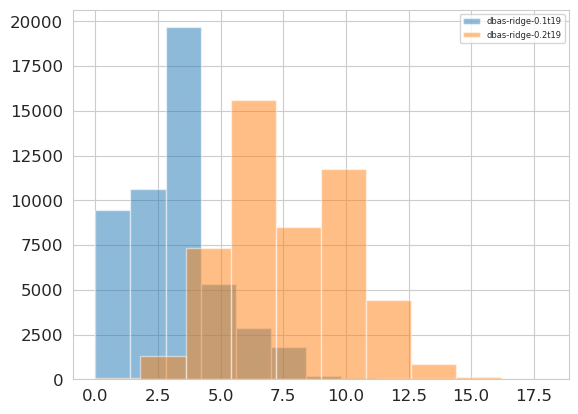

In [24]:
for name, data in name2designdata.items():
    if 'dbas-ridge' in name:
        seq_n, _, _ = data
        designed_n = np.array([editdistance.eval(rna.RNABinding.SEEDS[3], seq) for seq in seq_n])
        plt.hist(designed_n, alpha=0.5, label=name)
        plt.legend(fontsize=6)

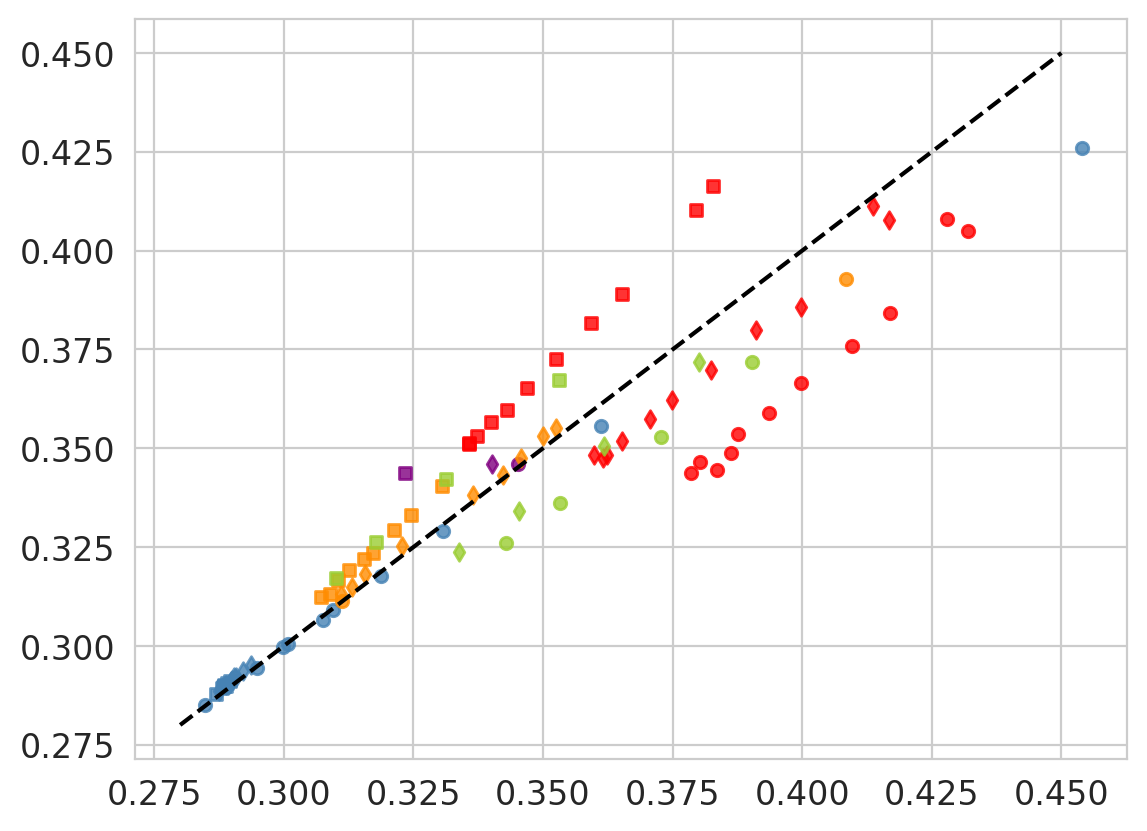

In [35]:
plt.figure(dpi=200)
for name, (seq_n, y_n, pred_n) in name2designdata.items():
    if 'train' in name:
        continue
        
    if 'adalead' in name:
        c = 'red'
    elif 'biswas' in name:
        c = 'yellowgreen'
    elif 'cbas' in name:
        c = 'steelblue'
    elif 'dbas' in name:
        c = 'darkorange'
    elif 'pex' in name:
        c = 'purple'
        
    if 'ridge' in name:
        m = 'o'
    elif 'ff' in name:
        m = 'd'
    elif 'cnn' in name:
        m = 's'
    plt.scatter(np.mean(pred_n), np.mean(y_n), marker=m, c=c, s=20, alpha=0.8)
plt.plot([0.28, 0.45], [0.28, 0.45], '--k');

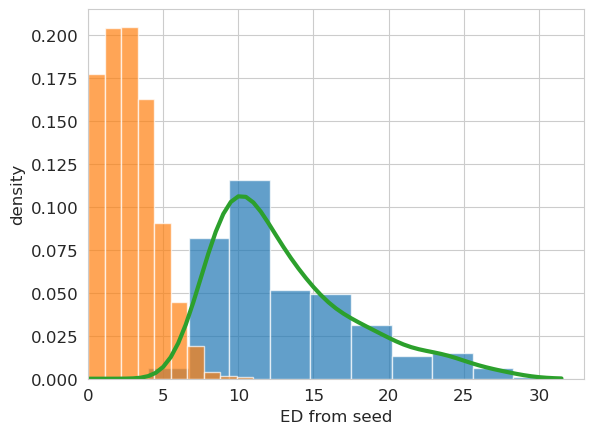

In [78]:
seq_n, y_n, pred_n = name2designdata['adalead-ff-0.05']
ed_N = np.array([editdistance.eval(rna.RNABinding.SEEDS[3], seq) for seq in seq_n])
plt.hist(ed_N, density=True, alpha=0.7);

trained_n = np.array([editdistance.eval(rna.RNABinding.SEEDS[3], seq) for seq in trainseqs_n])
plt.hist(trained_n, density=True, alpha=0.7);

kde = KernelDensity(bandwidth=1, kernel='gaussian', metric='euclidean')
kde.fit(ed_N[:, None])

x = np.arange(0, np.max(ed_N) + 1, 0.5)[:, None]
density = np.exp(kde.score_samples(x))
plt.plot(x, density, linewidth=3);
plt.xlabel('ED from seed');
plt.ylabel('density');
plt.xlim([0, np.max(ed_N) + 2]);

In [41]:
import utils
from sklearn.decomposition import PCA

In [60]:
design_name = 'adalead-ridge-0.5'
seq_n, y_n, pred_n = name2designdata[design_name]
ohe_nxlxa = models.type_check_and_one_hot_encode_sequences(seq_n, utils.RNA_NUCLEOTIDES)
ohe_nxla = np.reshape(ohe_nxlxa, (len(seq_n), 50 * len(utils.RNA_NUCLEOTIDES)))
trainohe_nxlxa = models.type_check_and_one_hot_encode_sequences(trainseqs_n, utils.RNA_NUCLEOTIDES)
trainohe_nxla = np.reshape(trainohe_nxlxa, (len(trainseqs_n), 50 * len(utils.RNA_NUCLEOTIDES)))

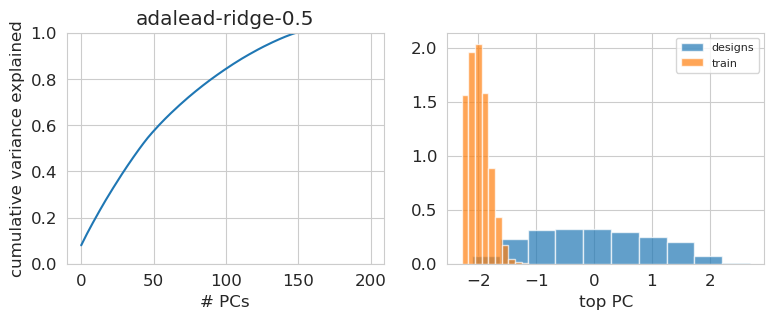

In [73]:
pca = PCA()
pca.fit(np.vstack([ohe_nxla]))
pc_nxc = pca.transform(np.vstack([ohe_nxla, trainohe_nxla]))

plt.figure(figsize=(9, 3))
plt.subplot(121)
plt.title(design_name)
plt.plot(np.cumsum(pca.explained_variance_ratio_));
plt.ylabel('cumulative variance explained');
plt.ylim([0, 1])
plt.xlabel('# PCs')

plt.subplot(122)
plt.hist(pc_nxc[: len(seq_n), 0], alpha=0.7, density=True, label='designs');
plt.xlabel('top PC');
plt.hist(pc_nxc[len(seq_n) :, 0], alpha=0.7, density=True, label='train');
plt.legend(fontsize=8);

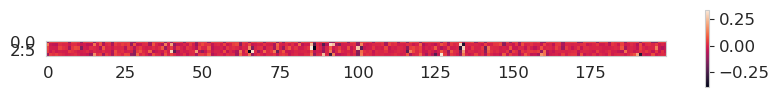

In [74]:
plt.figure(figsize=(10, 1))
plt.imshow(pca.components_[: 5, :])
plt.colorbar()
plt.grid(None)

In [90]:
def get_pp_mean_estimate(
    trainseq_n, designseq_N, preddesign_N, calseq_n, ycal_n, predcal_n, idxs
):
    seed = rna.RNABinding.SEEDS[3]
    designed_Nx = []
    trained_nx = []
    caled_nx = []
    for i, idx in enumerate(idxs[: -1]):
        designed_N = np.array([editdistance.eval(seed[idx : idxs[i + 1]], seq[idx : idxs[i + 1]]) for seq in designseq_N])
        trained_n = np.array([editdistance.eval(seed[idx : idxs[i + 1]], seq[idx : idxs[i + 1]]) for seq in trainseq_n])
        caled_n = np.array([editdistance.eval(seed[idx : idxs[i + 1]], seq[idx : idxs[i + 1]]) for seq in calseq_n])
        designed_Nx.append(designed_N[:, None])
        trained_nx.append(trained_n[:, None])
        caled_nx.append(caled_n[:, None])
    designed_Nx = np.hstack(designed_Nx)
    trained_nx = np.hstack(trained_nx)
    caled_nx = np.hstack(caled_nx)
        
    train_kde = KernelDensity(bandwidth=1, kernel='gaussian', metric='euclidean')
    train_kde.fit(trained_nx)
    ptraincal_n = np.exp(train_kde.score_samples(caled_nx))
    
    design_kde = KernelDensity(bandwidth=1, kernel='gaussian', metric='euclidean')
    design_kde.fit(designed_Nx)
    pdesigncal_n = np.exp(design_kde.score_samples(caled_nx))
    caldr_n = pdesigncal_n / ptraincal_n
    caldr_n = caldr_n / np.sum(caldr_n)

    pp_estimate = np.mean(preddesign_N) + np.mean(caldr_n * (ycal_n - predcal_n))
    return pp_estimate, caldr_n, designed_Nx, trained_nx, caled_nx

def get_pp_mean_estimate2(
    trainseq_n, designseq_N, preddesign_N, calseq_n, ycal_n, predcal_n, n_pc
):
    
    designohe_nxlxa = models.type_check_and_one_hot_encode_sequences(designseq_N, utils.RNA_NUCLEOTIDES)
    designohe_nxla = np.reshape(designohe_nxlxa, (len(designseq_N), 50 * len(utils.RNA_NUCLEOTIDES)))
    pca = PCA(n_components=n_pc)
    designpc_nxc = pca.fit_transform(designohe_nxla)
    
    trainohe_nxlxa = models.type_check_and_one_hot_encode_sequences(trainseq_n, utils.RNA_NUCLEOTIDES)
    trainohe_nxla = np.reshape(trainohe_nxlxa, (len(trainseq_n), 50 * len(utils.RNA_NUCLEOTIDES)))
    trainpc_nxc = pca.transform(trainohe_nxla)
        
    train_kde = KernelDensity(bandwidth=0.1, kernel='gaussian', metric='euclidean')
    train_kde.fit(trainpc_nxc)
    
    design_kde = KernelDensity(bandwidth=0.1, kernel='gaussian', metric='euclidean')
    design_kde.fit(designpc_nxc)
    
    calohe_nxlxa = models.type_check_and_one_hot_encode_sequences(calseq_n, utils.RNA_NUCLEOTIDES)
    calohe_nxla = np.reshape(calohe_nxlxa, (len(calseq_n), 50 * len(utils.RNA_NUCLEOTIDES)))
    calpc_nxc = pca.transform(calohe_nxla)
    
    ptraincal_n = np.exp(train_kde.score_samples(calpc_nxc))
    pdesigncal_n = np.exp(design_kde.score_samples(calpc_nxc))
    caldr_n = pdesigncal_n / ptraincal_n
    caldr_n = caldr_n / np.sum(caldr_n)

    pp_estimate = np.mean(preddesign_N) + np.mean(caldr_n * (ycal_n - predcal_n))
    return pp_estimate, caldr_n

In [5]:
train_fname = '/data/wongfanc/rna-models/traindata-nsd0.02-040324.npz'

# load training data and fit ridge regression
d = np.load(train_fname)
trainseqs_n = list(d['trainseq_n'])
ytrain_n = d['ytrain_n']
ridge = models.RidgeRegressor(seq_len=50, alphabet=rna.RNA_NUCLEOTIDES)
ridge.fit(trainseqs_n, ytrain_n)

# load trained FF and CNN models
ff_fname = '/data/wongfanc/rna-models/ff-n10000-nsd0.02-h100-092324.pt'
ff = models.FeedForward(50, rna.RNA_NUCLEOTIDES, 100)
ff.load(ff_fname)
cnn_fname = '/data/wongfanc/rna-models/cnn-n10000-nsd0.02-h100-092324.pt'
cnn = models.CNN(50, rna.RNA_NUCLEOTIDES, 32, 100)
cnn.load(cnn_fname)
name2model = {
    'ridge': ridge,
    'ff': ff,
    'cnn': cnn
}

In [86]:
calibration_pkl_fname = '/data/wongfanc/rna-data/calibration-pm0.08-nsd0.02_041524_2.pkl'
trial_idx = 0
model_name = 'ff'
design_name = f'adalead-{model_name}-0.2'

# load calibration data
with open(calibration_pkl_fname, 'rb') as f:
    caldata_t = pickle.load(f)
    
calseqs_n, ycal_n = caldata_t[trial_idx]
predcal_n = name2model[model_name].predict(calseqs_n)

designseq_N, ydesign_N, preddesign_N = name2designdata[design_name]

Text(0.5, 1.0, 'Spearman 0.06')

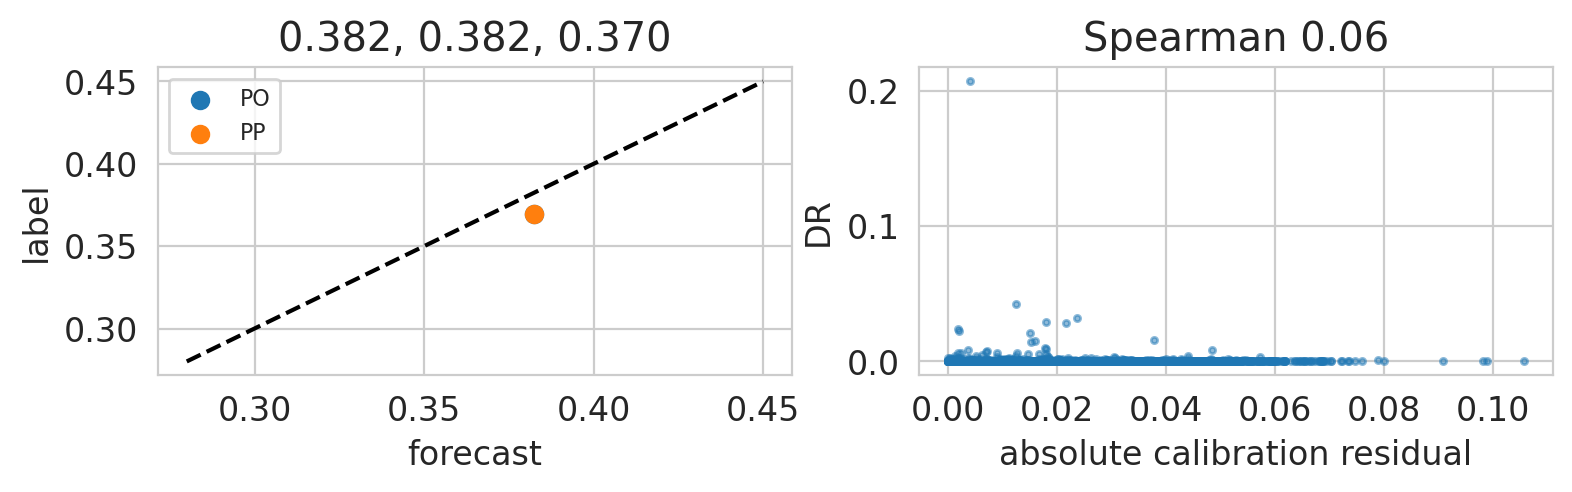

In [91]:
n_pc = 1
pp_mean, caldr_n = get_pp_mean_estimate2(
    trainseqs_n + calseqs_n,
    designseq_N,
    preddesign_N,
    calseqs_n,
    ycal_n,
    predcal_n,
    n_pc
)


plt.figure(figsize=(9, 2), dpi=200)
plt.subplot(121)
plt.scatter(np.mean(preddesign_N), np.mean(ydesign_N), label='PO')
plt.scatter(pp_mean, np.mean(ydesign_N), label='PP')
plt.legend(fontsize=8)
plt.plot([0.28, 0.45], [0.28, 0.45], '--k');
plt.xlabel('forecast'); plt.ylabel('label');
plt.title('{:.3f}, {:.3f}, {:.3f}'.format(np.mean(preddesign_N), pp_mean, np.mean(ydesign_N)))


plt.subplot(122)
plt.scatter(np.abs(ycal_n - predcal_n), caldr_n, s=5, alpha=0.5);
plt.xlabel('absolute calibration residual'); plt.ylabel('DR');
rho, _ = sc.stats.spearmanr(np.abs(ycal_n - predcal_n), caldr_n)
plt.title('Spearman {:.2f}'.format(rho))


# plt.subplot(133)
# n_segment = designed_Nx.shape[1]
# for d in range(n_segment):
#     alpha = 1 - d * (1 / n_segment)
#     plt.hist(designed_Nx[:, d], alpha=alpha, density=True, color='darkorange', label=design_name if d == 0 else None);
#     plt.hist(trained_nx[:, d], alpha=alpha, density=True, color='steelblue', label='train' if d == 0 else None);
# plt.legend(fontsize=8)
# plt.xlabel('{} subsequence EDs'.format(idxs)); plt.ylabel('density');
